In [98]:
libraries = c("dplyr", "tidyverse", "magrittr", "ggpubr", "rworldmap", "MASS", "Rlab")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

theme_set(theme_bw())

In [99]:
time_0 <- as.Date("2022-04-17") ## the date of symptom onset of the initial case in the UK
time_end <- as.Date("2022-10-02") ## the end date of study period

In [100]:
## MPX incidence data (the WHO data)
path <- "../data/incidence/WHO_dashboard/"
list.files(path = path, pattern = "*csv") -> file_list
read_csv_files <- function(x){return(suppressMessages(read.csv(paste0(path, x))))}
lapply(file_list, read_csv_files) -> df_list

do.call(rbind, df_list) %>% as.data.frame() %>% dplyr::select(-c("who_region", "who_region_long")) %>% 
rename(date=reference_date, iso_code=iso3, new_cases=cases, location=country) -> df_inci
df_inci$date <- as.Date(df_inci$date)

## modifying China data (manually distinguishing Taiwan, Hong Kong, Mainland China)
df_inci %<>% mutate(iso_code=case_when(iso_code==c("CHN") & date < as.Date("2022-08-29") ~ c("TWN"),
                                       iso_code==c("CHN") & date == as.Date("2022-09-28") ~ c("TWN"),
                                       iso_code==c("CHN") & date == as.Date("2022-08-30") ~ c("HKG"),
                                       TRUE ~ iso_code),
                    location=case_when(iso_code==c("TWN") ~ c("Taiwan, Province of China"), 
                                       iso_code==c("HKG") ~ c("Hong Kong"), TRUE ~ location))

## adding missing countries with the manually collected Global.health data (by the date of repoting)
read.csv("../data/incidence/df_inci_Github.csv") -> df_global
df_global %>% filter(iso_code %in% c("ZAF", "PRY", "PRI", "MOZ", "MNE", "MTQ", "LBR", "JOR", "IRN", "GUM",
                                     "GLP", "BHR", "BEN", "BOL", "GHA", "CMR", "COG", "EGY", "GBZ", 
                                     "IND", "RUS", "MCO")) %>%
dplyr::select(Country, Date, Cases, iso_code) %>% mutate(date_type=c("Reported")) %>%
rename(location=Country, date=Date, new_cases=Cases) -> df_global
df_global$date <- as.Date(df_global$date, format="%Y-%m-%d")
rbind(df_inci, df_global) -> df_inci

## removing cases before the current global outbreak
df_inci %<>% filter(!(location==c("Singapore") & date <= as.Date("2022-05-01"))) %>%
filter(!(location==c("Brazil") & date <= as.Date("2022-05-01"))) %>%
filter(!(location==c("Czechia") & date <= as.Date("2022-05-01"))) %>%
group_by(location) %>% filter(date < time_end)

     meanlog        sdlog         sigma   
  1.861100444   0.651295117   0.178270835 
 (0.002892104) (0.002045016) (0.001540624)

[1] 7.950168

[1] 6.43081

[1] 5.778765

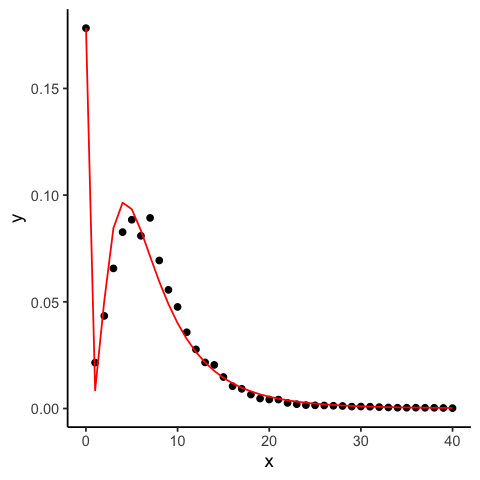

In [101]:
## estimating the mean value of the WHO reporting delay: zero-inflated lognoraml distribution
read.csv("../data/delay_WHO.csv") -> df_delay
df_delay %>% filter(reporting_delay >=0) -> df_delay_pos
rep(df_delay_pos$reporting_delay, df_delay_pos$cases) -> value_pos

dzip <- function (x, meanlog, sdlog, sigma){
    ifelse((x == 0), (dbern(1, sigma, log=FALSE)),dbern(0, sigma, log=FALSE)*dlnorm(x, meanlog, sdlog, log=FALSE))
}
(fit_zip = fitdistr(value_pos, dzip, start = list(meanlog = 1.7, sdlog=0.5, sigma = 0.3), lower = list(p = 0.00001)))

(est_mean <- exp(as.numeric(fit_zip[[1]][1]) + (1/2)*as.numeric(fit_zip[[1]][2])^2))
(est_median <- exp(as.numeric(fit_zip[[1]][1])))
(est_sd <- exp(as.numeric(fit_zip[[1]][1]) + (1/2)*as.numeric(fit_zip[[1]][2])^2)*sqrt(exp(as.numeric(fit_zip[[1]][2])^2) - 1))

## checking the fitting
point <- as.data.frame(table(value_pos)); names(point) <- c("x","y")
point <- transform(point,x=as.numeric(as.character(x)))
point$y <- point$y/sum(point[,2])

options(repr.plot.width=4,repr.plot.height=4)
ggplot() + 
geom_point(data = point,aes(x = x,y = y)) +     
geom_line(aes(x=point[,1],y=ifelse((point[,1]==0),(dbern(1, 0.178270835)), 
                                   dbern(0, 0.178270835)*dlnorm(point[,1], 1.861100444, 0.651295117))),color="red") + 
theme_classic()

In [102]:
## dataset for the first reported cases
df_inci %>% arrange(date) %>% group_by(location) %>% filter(rank(date)==1) %>% ungroup() -> df_first

## backprojecting the first cases with surveillance package
library(surveillance)

df_first %>% filter(!(date_type==c("Onset"))) %>%
filter(!(iso_code %in% c("CMR","LBR","CAF","NGA","COD","COG","GHA"))) -> df_first_report
as.data.frame(seq(as.Date("2021-12-01"), max(df_first$date), by=c("day"))) -> temp_cal
colnames(temp_cal) <- c("date")

unique(df_first_report$location) -> backproj_country
backproj_list <- list()

for (i in 1:length(backproj_country)){
    df_first_report %>% filter(location==backproj_country[i]) %>% dplyr::select(iso_code) %>% 
    unique() %>% as.character() -> iso_info
    merge(temp_cal, df_first_report %>% filter(location==backproj_country[i]), 
          by=c("date"), all.x=TRUE) -> df_backproj
    
    ## adding extra 10 days for the stability of back-projection procedure
    as.data.frame(seq((max(df_first$date)+1), (max(df_first$date)+10), by=c("day"))) -> temp_lastdays
    colnames(temp_lastdays) <- c("date")
    temp_lastdays %<>% mutate(location=NA, iso_code=NA, date_type=c("Reported"), new_cases=0)
    rbind(df_backproj, temp_lastdays) %>% 
    mutate(location=backproj_country[i], iso_code=iso_info, date_type=c("Reported"),
           new_cases=case_when(is.na(new_cases)~0, TRUE~new_cases)) -> df_backproj
    df_backproj %<>% mutate(t = 1:nrow(df_backproj)) 
    
    ## time delay from the symptom onset to reporting
    K = nrow(df_backproj)
    report_probability = plnorm(1:K, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2])) - 
                         plnorm(1:K-1, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2]))
    report_pmf = c(0,report_probability[1:21])

    ## back-projecton of domestic cases
    sts = new("sts", epoch=df_backproj$t, observed=df_backproj$new_cases)
    bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), Tmark = nrow(sts), B = -1, 
                        alpha = 0.01, verbose = FALSE, lambda0 = NULL, eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_backproj$total_backproj = upperbound(sts_bp)

    ## normalizing the back-projected cases
    df_backproj$total_backproj[df_backproj$total_backproj<=0.01] <- 0

    df_backproj %>% mutate(total_normal = total_backproj/sum(total_backproj)*sum(new_cases)) %>%
    dplyr::select(-c("new_cases","total_backproj", "t")) %>% rename(new_cases=total_normal) %>% 
    mutate(date_type=c("Onset")) -> backproj_list[[i]]    
}

do.call(rbind, backproj_list) -> backproj_final

## merging the dataset with the back-projected cases
df_first %>% filter(date_type==c("Onset")) -> temp_onset
rbind(temp_onset, backproj_final) %>%
group_by(location, date, iso_code) %>% summarise(total_new_cases=sum(new_cases)) %>% 
ungroup() %>% rename(new_cases=total_new_cases) %>% filter(new_cases > 0) -> df_first_backproj

`summarise()` has grouped output by 'location', 'date'. You can override using
the `.groups` argument.


In [103]:
## backprojecting all cases with surveillance package
df_inci %>% filter(date_type %in% c("Diagnosis", "Reported")) %>% ungroup() -> df_inci_report
as.data.frame(seq(as.Date("2021-12-01"), max(df_inci$date), by=c("day"))) -> temp_cal; colnames(temp_cal) <- c("date")

unique(df_inci_report$location) -> backproj_country
backproj_list <- list()
for (i in 1:length(backproj_country)){
    df_inci_report %>% filter(location==backproj_country[i]) %>% dplyr::select(iso_code) %>% 
     unique() %>% as.character() -> iso_info
     merge(temp_cal, df_inci_report %>% filter(location==backproj_country[i]), 
           by=c("date"), all.x=TRUE) -> df_backproj
    
    ## adding extra 10 days for the stability of back-projection procedure
    as.data.frame(seq((max(df_inci$date)+1), (max(df_inci$date)+10), by=c("day"))) -> temp_lastdays
    colnames(temp_lastdays) <- c("date")
    temp_lastdays %<>% mutate(location=NA, iso_code=NA, date_type=c("Reported"), new_cases=0)
    rbind(df_backproj, temp_lastdays) %>% 
    mutate(location=backproj_country[i], iso_code=iso_info, date_type=c("Reported"),
           new_cases=case_when(is.na(new_cases)~0, TRUE~new_cases)) -> df_backproj
    df_backproj %<>% mutate(t = 1:nrow(df_backproj)) 
    
    
    ## time delay from the symptom onset to reporting
    K = nrow(df_backproj)
    report_probability = plnorm(1:K, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2])) - 
                         plnorm(1:K-1, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2]))
    report_pmf = c(0,report_probability[1:21])

    
    ## back-projecton of domestic cases
    sts = new("sts", epoch=df_backproj$t, observed=df_backproj$new_cases)
    bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                        Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_backproj$total_backproj = upperbound(sts_bp)


    ## normalizing the back-projected cases
    df_backproj$total_backproj[df_backproj$total_backproj<=0.01] <- 0

    df_backproj %>% mutate(total_normal = total_backproj/sum(total_backproj)*sum(new_cases)) %>%
    dplyr::select(-c("new_cases","total_backproj", "t")) %>% rename(new_cases=total_normal) %>% 
    mutate(date_type=c("Onset")) -> backproj_list[[i]]    
}

do.call(rbind, backproj_list) -> backproj_final

## merging the dataset with the back-projected cases
df_inci %>% filter(date_type==c("Onset")) -> temp_onset
rbind(temp_onset, backproj_final) %>%
group_by(location, date, iso_code) %>% summarise(total_new_cases=sum(new_cases)) %>% 
ungroup() %>% rename(new_cases=total_new_cases) %>% filter(new_cases > 0) -> df_inci

## date of the first importation
df_inci %>% arrange(date) %>% group_by(location) %>% filter(rank(date)==1) %>% 
dplyr::select(location, date) %>% rename(date_import = date) -> temp
merge(df_inci, temp, by=c("location"), all.x=TRUE) %>% arrange(location, date) %>%
filter(!(iso_code %in% c("CMR","LBR","CAF","NGA","COD","COG","GHA"))) -> df_inci

`summarise()` has grouped output by 'location', 'date'. You can override using
the `.groups` argument.


In [110]:
## checking differences between backprojected dates
df_first_backproj %>% filter(new_cases < 1) -> temp
df_inci %>% filter(location %in% unique(temp$location)) -> temp2

merge(temp, temp2, by=c("location", "iso_code", "date"), all=TRUE) %>% group_by(location) %>% top_n(-3, date) %>%
mutate(diff=abs(new_cases.x-new_cases.y)) %>% filter(diff >= 1e-02) 

location,iso_code,date,new_cases.x,new_cases.y,date_import,diff
<chr>,<chr>,<date>,<dbl>,<dbl>,<date>,<dbl>
Bolivia,BOL,2022-07-24,0.04959851,0.01999377,2022-07-24,0.02960474
Bolivia,BOL,2022-07-25,0.12248459,0.08542803,2022-07-24,0.03705656
Iceland,ISL,2022-06-05,0.09919701,0.08150104,2022-06-04,0.01769597
India,IND,2022-07-06,0.04959851,0.02060800,2022-07-06,0.02899051
India,IND,2022-07-07,0.12248459,0.07406873,2022-07-06,0.04841586
Puerto Rico,PRI,2022-06-21,0.04959851,0.03880452,2022-06-20,0.01079398
Puerto Rico,PRI,2022-06-22,0.12248459,0.10785472,2022-06-20,0.01462987
South Africa,ZAF,2022-06-14,0.04959851,0.03137139,2022-06-14,0.01822712
South Africa,ZAF,2022-06-15,0.12248459,0.09773226,2022-06-14,0.02475233


In [52]:
## adding dates with zero case and calculating the cumulative number of cases
as.data.frame(seq(min(df_inci$date), time_end, by="day")) -> temp_cal; colnames(temp_cal) <- c("date") 
unique(df_inci$location) -> MPX_country_list
df_inci$date <- as.Date(df_inci$date); temp_cal$date <- as.Date(temp_cal$date); 

df_inci_list <- list()
for(i in 1:length(MPX_country_list)){
    df_inci %>% filter(location==MPX_country_list[i]) -> temp_inci
    merge(temp_cal, temp_inci, by=c("date"), all.x=TRUE) -> temp_inci_all

    temp_inci_all$location[is.na(temp_inci_all$location)] <- unique(temp_inci$location)
    temp_inci_all$iso_code[is.na(temp_inci_all$iso_code)] <- unique(temp_inci$iso_code)
    temp_inci_all$new_cases[is.na(temp_inci_all$new_cases)] <- 0
    temp_inci_all$date_import[is.na(temp_inci_all$date_import)] <- unique(temp_inci$date_import)
    
    temp_inci_all %>% dplyr::select(location, iso_code, date, new_cases, date_import) %>%
    group_by(location) %>% mutate(total_cases=cumsum(new_cases)) -> df_inci_list[[i]]    
}

do.call("rbind", df_inci_list) %>% as.data.frame() %>% arrange(location, date) -> df_inci
write.csv(df_inci, "../data/incidence/df_inci_WHO.csv")

In [53]:
## MSM population
read.csv("../data/MSM_pop/df_MSM_UNAIDS.csv") -> df_MSM1
read.csv("../data/MSM_pop/df_full_list_MSMsize_Fumi.csv") -> df_MSM2

## revising the pop2022 column from df_MSM2
read.csv("../data/MSM_pop/df_pop_raw.csv") %>% dplyr::select(cca2, pop2022) %>% rename(iso_2=cca2) -> df_pop1
read.csv("../data/MSM_pop/df_region.csv") %>% dplyr::select(alpha.2,alpha.3, name) %>%
rename(iso_2=alpha.2, iso_code=alpha.3, location=name) -> df_pop2
merge(df_pop1, df_pop2, by=c("iso_2")) -> df_pop
merge(df_MSM2 %>% dplyr::select(-pop2022), 
      df_pop %>% dplyr::select(iso_code, pop2022), by=c("iso_code"), all.x=TRUE) -> df_MSM2

## giving a priority to UNAIDS dashboard
merge(df_MSM1, df_MSM2, by=c("location"),all=TRUE) %>% 
dplyr::select(location, iso_code, estimate, MSM_size, region, sub_region, pop2022) %>%
mutate(prop=estimate/pop2022) %>%
mutate(imputed=case_when(!is.na(estimate) ~ estimate, is.na(estimate) & !is.na(MSM_size) ~ MSM_size), 
       prop=imputed/pop2022) -> temp

## imputation of missing values
temp %>% group_by(sub_region) %>% drop_na(imputed) %>% summarise(prop_avg = mean(prop)) -> prop_avg
merge(temp, prop_avg, by=c("sub_region"), all.x=TRUE) %>% drop_na(pop2022) %>%
mutate(prop=case_when(!is.na(prop)~prop, is.na(prop)~prop_avg),
       imputed=case_when(!is.na(imputed)~imputed, is.na(imputed)~prop*pop2022)) -> df_MSM_imputed

## modifying Samoa data with the value from UNAIDS reports
df_MSM_imputed %>% mutate(imputed=case_when(location==c("Samoa")~MSM_size, TRUE~imputed),
                          prop=case_when(location==c("Samoa")~MSM_size/pop2022, TRUE~prop)) -> df_MSM_imputed

write.csv(df_MSM_imputed, "../data/MSM_pop/df_MSM_imputed.csv")

In [54]:
## merging incidence data with MSM population data
merge(df_inci, df_MSM_imputed %>% dplyr::select(iso_code, imputed, pop2022, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) -> df_all_inci
write.csv(df_all_inci, "../data/MSM_pop/df_all_inci_WHO_backproj.csv")

In [55]:
## applying a 14-day moving average for the newly reported and cumulative case counts
df_all_inci %>% group_by(location) %>% arrange(date) %>%
mutate(MA_new_cases = zoo::rollmean(new_cases, k=14, align="right", fill=NA),
       MA_total_cases = zoo::rollmean(total_cases, k=14, align="right", fill=NA)) -> temp
temp$MA_new_cases[is.na(temp$MA_new_cases)]<-0; temp$MA_total_cases[is.na(temp$MA_total_cases)]<-0; 

temp %<>% mutate(MA_new_cases=case_when(MA_new_cases<0 ~ 0, TRUE ~ MA_new_cases),
                 MA_total_cases=case_when(MA_total_cases<0 ~ 0, TRUE ~ MA_total_cases))

## calculating the cumlative incidence proportion (i.e., cumulative incidecne/MSM population)
temp %>% rename(MSM_pop=imputed) %>% mutate(MSM_pop=MSM_pop*1000) %>% 
group_by(location) %>% mutate(cum_icni_prop=MA_total_cases/(MSM_pop)) %>%
dplyr::select(iso_code, location, region, sub_region, date, new_cases, total_cases, MA_new_cases, MA_total_cases,
              date_import, MSM_pop, pop2022, cum_icni_prop) %>%
filter(date >= time_0) -> df_inci_MA

write.csv(df_inci_MA, "../data/df_inci_final_WHO_backproj.csv")

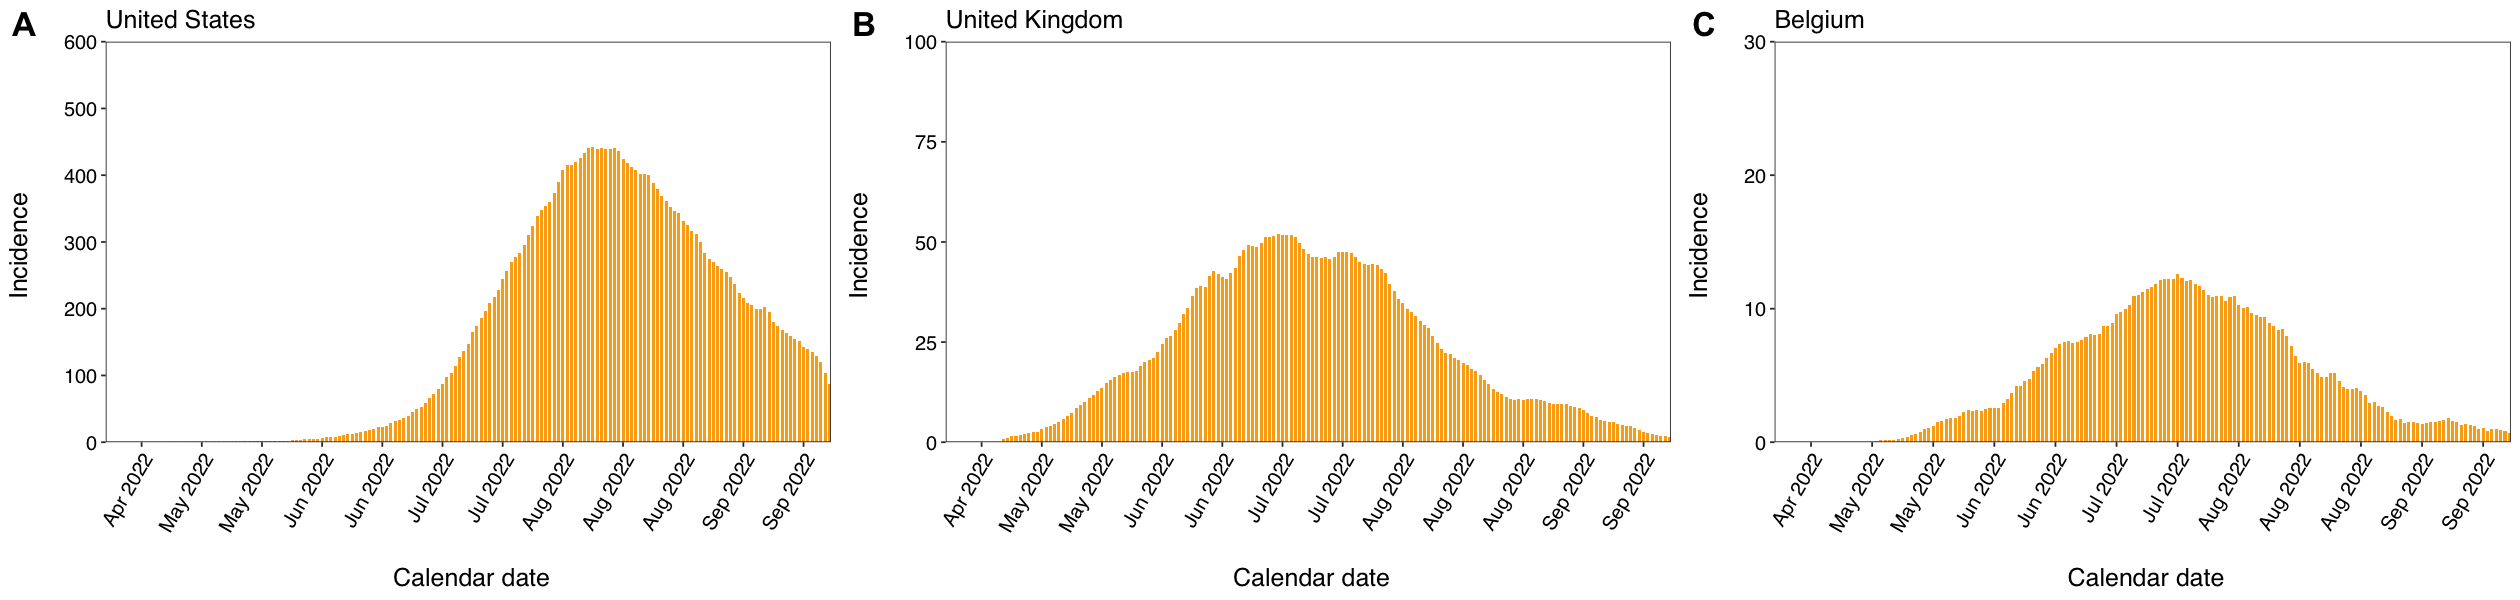

In [56]:
## checking the smoothened incidence with the 14-day moving average
options(repr.plot.width=7,repr.plot.height=5)
df_inci_MA %>% filter(iso_code==c("USA")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("United States") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,600)) -> Fig1

df_inci_MA %>% filter(iso_code==c("GBR")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("United Kingdom") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,100)) -> Fig2

df_inci_MA %>% filter(location==c("Belgium")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("Belgium") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,30)) -> Fig3

options(repr.plot.width=21,repr.plot.height=5)
ggarrange(Fig1, Fig2, Fig3, ncol = 3, nrow = 1, labels = c("A", "B", "C"), font.label = list(size = 20))

In [57]:
library(lubridate)
bimonthly <- function(x) {
  x_range <- range(x, na.rm = TRUE)
  
  date_range <- c(
    floor_date(x_range[1], "month"),
    ceiling_date(x_range[2], "month")
  )
  monthly <- seq(date_range[1], date_range[2], by = "1 month")
  
  sort(c(monthly, monthly + days(14)))
}

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 12 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”


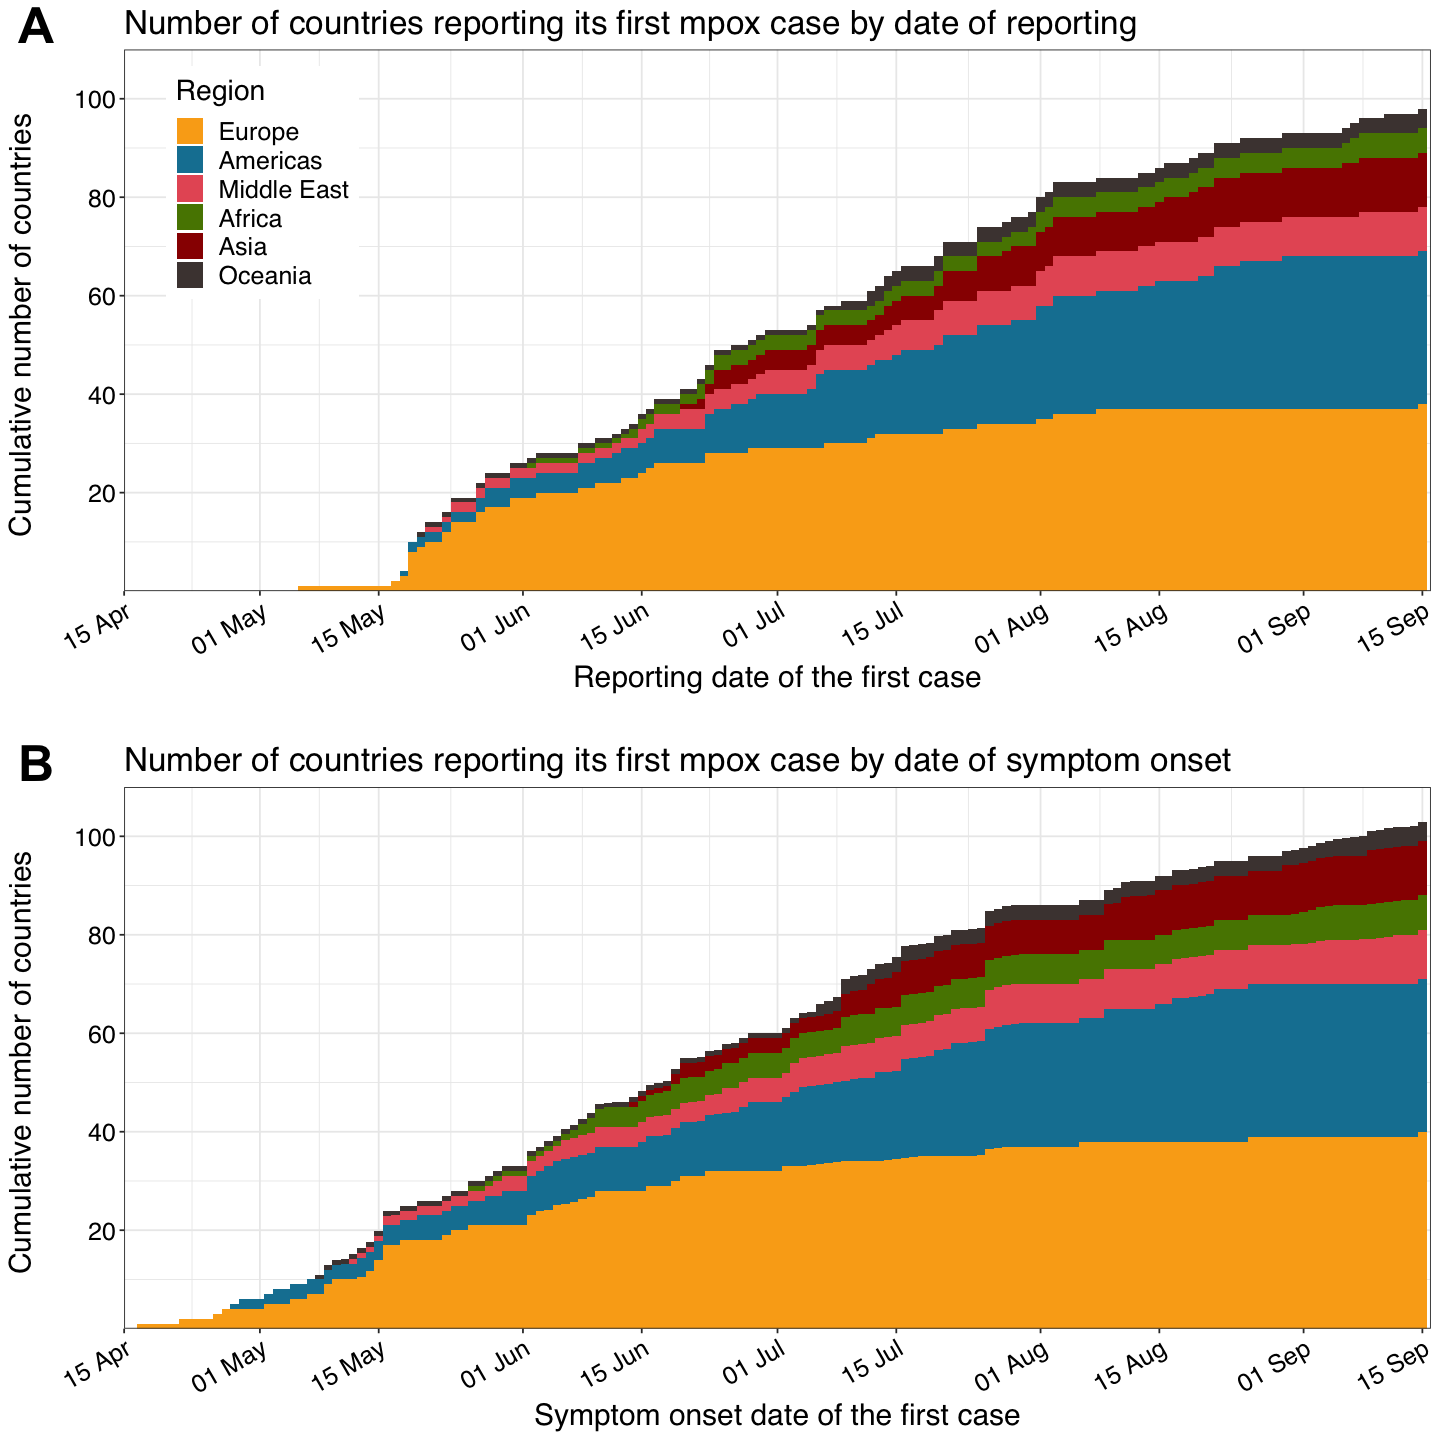

In [58]:
#### Discriptive figure
## with the reporting date
read.csv("../data/incidence/df_inci_Github.csv") %>% arrange(Country, Date) %>% 
mutate(date_import_adj=case_when(iso_code==c("CHN")~ as.Date("2022-06-24"), TRUE~as.Date(date_import))) %>%
dplyr::select(Country, iso_code, date_import_adj) %>% rename(date_import=date_import_adj) %>% 
distinct() -> df_reporting

df_inci_MA %>% ungroup() %>% 
mutate(region_adj = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) %>%
dplyr::select(region_adj, iso_code) %>% rename(region=region_adj) %>% distinct() -> temp

merge(df_reporting, temp, by=c("iso_code")) -> df_fig
as.Date(df_fig$date_import) -> df_fig$date_import
df_fig$region <- factor(df_fig$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

df_fig %>% filter(date_import >= as.Date("2022-04-15")) %>% dplyr::count(date_import, region) -> temp
as.data.frame(rep(seq(min(temp$date_import), max(temp$date_import), 1), each=6)) -> temp2
colnames(temp2) <- ("date_import")
temp2 %<>% mutate(region=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(temp$date_import), max(temp$date_import), 1))))
merge(temp2, temp, by=c("date_import", "region"), all.x=TRUE) -> df_fig_cum
df_fig_cum[is.na(df_fig_cum)] <-0
df_fig_cum %<>% group_by(region) %>% mutate(count=cumsum(n)) %>% ungroup() 

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_fig_cum, aes(x = date_import, y=count, fill = fct_reorder(region, count))) +
geom_bar(stat="identity", width=1) +
scale_fill_viridis_d(direction = 1) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x=element_text(angle=30, hjust=1),
      legend.position = c(0.18, .97),
      legend.justification = c("right", "top"), legend.box.just = "left", legend.margin = margin(6, 6, 6, 6)) +
xlab("Reporting date of the first case") +
ylab("Cumulative number of countries \n") +
ggtitle("Number of countries reporting its first mpox case by date of reporting") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(df_fig$date_import)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20,40,60,80,100)) +
coord_cartesian(ylim = c(0,110)) -> Fig1


## with the symptom onset date
merge(df_first_backproj, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% filter(date >= as.Date("2022-04-15")) %>% 
mutate(region=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region),
       weight=case_when(new_cases >=1 ~ 1, 
                        iso_code %in% c("ISL") ~ new_cases/2, ## back-projected 2 cases
                        iso_code %in% c("BEN") ~ new_cases/3, ## back-projected 3 cases
                        TRUE~new_cases)) -> df_fig2

df_fig2$region <- factor(df_fig2$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

as.data.frame(rep(seq(min(df_fig2$date), max(df_fig2$date), 1), each=6)) -> temp2; colnames(temp2) <- ("date")
temp2 %<>% mutate(region=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(df_fig2$date), max(df_fig2$date), 1))))
merge(temp2, df_fig2, by=c("date", "region"), all.x=TRUE) -> df_fig_cum2
df_fig_cum2[is.na(df_fig_cum2)] <-0

df_fig_cum2 %<>% group_by(region) %>% mutate(count=cumsum(weight)) %>% ungroup() %>% 
group_by(region, date) %>% top_n(1, count) %>% dplyr::select(date, region, iso_code, count)

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_fig_cum2, aes(x = date, y=count, fill = fct_reorder(region, count))) +
geom_bar(stat="identity", width=1) +
scale_fill_viridis_d(direction = 1) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.position="none",
      axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Symptom onset date of the first case") +
ylab("Cumulative number of countries \n") +
ggtitle("Number of countries reporting its first mpox case by date of symptom onset") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(df_fig$date_import)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20,40,60,80,100)) +
coord_cartesian(ylim = c(0,110)) -> Fig2

options(repr.plot.width=12,repr.plot.height=12)
ggarrange(Fig1, ggplot() + theme_void(), Fig2, ncol = 1, heights = c(1, 0.05, 1), 
          labels = c("A", "", "B"), font.label = list(size = 30), vjust=1.2)

ggsave("../figures/final_figures/Fig1.png", width = 12, height = 12, dpi=600)

In [59]:
setdiff(df_fig$iso_code, df_fig2$iso_code)
setdiff(df_fig2$iso_code, df_fig$iso_code)

character(0)

[1] "SMR" "VNM"

In [141]:
## Error bars for the back-projected first cases
df_fig2 %>% filter(weight < 1) %>% group_by(location) %>% mutate(cumul_dist=cumsum(weight)) %>%  
filter(abs(cumul_dist - 0.5) == min(abs(cumul_dist - 0.5))) %>% rename(date_med=date) %>% ungroup() %>%
dplyr::select(iso_code, date_med) -> weight_med

df_fig2 %>% filter(weight < 1) %>% group_by(location) %>% mutate(cumul_dist=cumsum(weight)) %>%  
filter(cumul_dist > 0.025) %>% filter(abs(cumul_dist - 0.025) == min(abs(cumul_dist - 0.025))) %>% 
rename(date_low=date) %>% ungroup() %>% dplyr::select(iso_code, date_low) -> weight_low

df_fig2 %>% filter(weight < 1) %>% group_by(location) %>% mutate(cumul_dist=cumsum(weight)) %>%  
filter(abs(cumul_dist - 0.975) == min(abs(cumul_dist - 0.975))) %>% rename(date_upp=date) %>% ungroup() %>%
dplyr::select(iso_code, date_upp) -> weight_upp

df_list <- list(weight_med, weight_low, weight_upp)
Reduce(function(x, y) merge(x, y, by=c("iso_code"), all=TRUE), df_list) -> date_interval

merge(df_fig2, date_interval, by=c("iso_code"), all=TRUE) %>% 
mutate(date_med=case_when(weight==1 ~ date, TRUE ~ date_med)) %>% 
dplyr::select(iso_code, location, region, sub_region, date_med, date_low, date_upp) %>% distinct() %>%
rename(Country=location, Date_reported=date_med) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("South Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         Country==c("Czech Republic")~c("Czechia"),
                         Country==c("Moldova")~c("Moldova, Republic of"),
                         Country==c("Bosnia And Herzegovina")~c("Bosnia and Herzegovina"),
                         Country==c("Russia")~c("Russian Federation"),
                         Country==c("United States")~c("United States of America"),
                         TRUE~Country)) -> df_mpox_arrival_all
       
## combining China-related regions
df_mpox_arrival_all %>% mutate(date_med=case_when(iso_code==c("CHN")~as.Date("2022-06-20"), TRUE~date_med)) %>%
filter(!iso_code %in% c("HKG", "TWN")) -> df_mpox_arrival
max(df_mpox_arrival$date_med)-min(df_mpox_arrival$date_med)+1
       
df_mpox_arrival %>% head()

,iso_code,Country,region,sub_region,date_med,date_low,date_upp
,<chr>,<chr>,<chr>,<chr>,<date>,<date>,<date>
1,ABW,Aruba,Americas,Latin America and the Caribbean,2022-08-09,NA,NA
2,AND,Andorra,Europe,Southern Europe,2022-06-20,NA,NA
3,ARE,United Arab Emirates,Middle East,Western Asia,2022-05-12,NA,NA
4,ARG,Argentina,Americas,Latin America and the Caribbean,2022-05-03,NA,NA
5,AUS,Australia,Oceania,Australia and New Zealand,2022-05-08,NA,NA
6,AUT,Austria,Europe,Western Europe,2022-05-14,NA,NA


In [143]:
df_inci_MA %>% head()

iso_code,location,region,sub_region,date,new_cases,total_cases,MA_new_cases,MA_total_cases,date_import,MSM_pop,pop2022,cum_icni_prop
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
ABW,Aruba,Americas,Latin America and the Caribbean,2022-04-17,0,0,0,0,2022-08-09,3587.1965,106.445,0
AND,Andorra,Europe,Southern Europe,2022-04-17,0,0,0,0,2022-06-20,576.5777,79.824,0
ARE,United Arab Emirates,Asia,Western Asia,2022-04-17,0,0,0,0,2022-05-12,96299.5158,9441.129,0
ARG,Argentina,Americas,Latin America and the Caribbean,2022-04-17,0,0,0,0,2022-05-03,205600.0000,45510.318,0
AUS,Australia,Oceania,Australia and New Zealand,2022-04-17,0,0,0,0,2022-05-08,263500.0000,26177.413,0
AUT,Austria,Europe,Western Europe,2022-04-17,0,0,0,0,2022-05-14,81238.9781,8939.617,0


In [ ]:
df_mpox_case %<>% arrange(Country)

cal <- as.data.frame(rep(seq(min(df_mpox_case$Date_reported),max(df_mpox_case$Date_reported),1),
                         length(unique(df_mpox_case$Country))))
colnames(cal) <- c("Date_reported")
cal %<>% mutate(Country=rep(unique(df_mpox_case$Country),
                          each=length(seq(min(df_mpox_case$Date_reported),max(df_mpox_case$Date_reported),1))))

merge(df_mpox_case %>% dplyr::select(Country, group), cal, by=c("Country")) %>% distinct() -> cal
merge(df_mpox_case %>% dplyr::select(-group), cal, by=c("Date_reported", "Country"), all.y=TRUE) %>%
dplyr::select(Date_reported, Country, Cases, group) -> df_mpox_case

df_mpox_case$Cases[is.na(df_mpox_case$Cases)] <- 0
df_mpox_case %>% group_by(Date_reported, group) %>% summarize(total_case=sum(Cases)) %>% ungroup() %>%
group_by(group) %>% mutate(cum_case=cumsum(total_case)) -> df_mpox_case

In [ ]:
# read.csv("../data/incidence/Github.csv") -> df_mpox
# df_mpox$Date <- as.Date(df_mpox$Date)
# max(df_mpox$Date)

# df_mpox %>% filter(Cumulative_cases > 0) %>% group_by(Country) %>% arrange(Date) %>% slice(1L) %>% ungroup() %>% 
# filter(Date >= as.Date("2022-05-01")) %>%
# filter(!Country %in% c("Ghana", "Liberia", "Congo", "Nigeria", "Cameroon", 
#                        "Democratic Republic Of The Congo", "Central African Republic")) %>%
# mutate(Country=case_when(Country==c("Hong Kong")~c("China"),
#                          Country==c("Taiwan")~c("China"),
#                          TRUE~Country))  %>%
# group_by(Country) %>% arrange(Date) %>% slice(1L) %>% ungroup() -> df_mpox_arrival


# read.csv("../data/incidence/df_inci_Github.csv") -> df_mpox_iso
# df_mpox_iso %<>% dplyr::select(Country, iso_code) %>% distinct()

# merge(df_mpox_arrival, df_mpox_iso, by=c("Country"), all.x=TRUE) -> df_mpox_arrival

# merge(df_mpox_arrival, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
#       by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
# mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
#                          TRUE~region)) %>%
# mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
#                          Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
#                          Country==c("South Korea")~c("Korea, Republic of"),
#                          Country==c("Türkiye")~c("Turkey"),
#                          Country==c("The United Kingdom") ~ c("United Kingdom"),
#                          Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
#                          Country==c("Iran")~c("Iran, Islamic Republic of"),
#                          Country==c("Réunion")~c("Reunion"),
#                          Country==c("Venezuela")~c("Venezuela, Bolivarian Republic of"),
#                          Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
#                          Country==c("Bolivia")~c("Bolivia, Plurinational State of"),
#                          Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
#                          Country==c("Curaçao")~c("Curacao"),
#                          Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
#                          Country==c("Czech Republic")~c("Czechia"),
#                          Country==c("Moldova")~c("Moldova, Republic of"),
#                          Country==c("Bosnia And Herzegovina")~c("Bosnia and Herzegovina"),
#                          Country==c("Russia")~c("Russian Federation"),
#                          Country==c("United States")~c("United States of America"),
#                          TRUE~Country)) %>% rename(Date_reported = Date) -> df_mpox_arrival

# max(df_mpox_arrival$Date_reported)-min(df_mpox_arrival$Date_reported)+1


# df_mpox %>% filter(Date >= as.Date("2022-05-01")) %>%
# filter(!Country %in% c("Ghana", "Liberia", "Republic of Congo", "Nigeria", "Cameroon", 
#                        "Democratic Republic Of The Congo", "Central African Republic")) %>%
# mutate(Country=case_when(Country==c("Hong Kong")~c("China"),
#                          Country==c("Taiwan")~c("China"),
#                          TRUE~Country)) -> df_mpox_case

# merge(df_mpox_case, df_mpox_iso, by=c("Country"), all.x=TRUE) -> df_mpox_case

# merge(df_mpox_case, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
#       by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
# mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
#                          TRUE~region)) %>% rename(Date_reported = Date) -> df_mpox_case

In [ ]:
df_mpox_case %<>% arrange(Country)

cal <- as.data.frame(rep(seq(min(df_mpox_case$Date_reported),max(df_mpox_case$Date_reported),1),
                         length(unique(df_mpox_case$Country))))
colnames(cal) <- c("Date_reported")
cal %<>% mutate(Country=rep(unique(df_mpox_case$Country),
                          each=length(seq(min(df_mpox_case$Date_reported),max(df_mpox_case$Date_reported),1))))

merge(df_mpox_case %>% dplyr::select(Country, group), cal, by=c("Country")) %>% distinct() -> cal
merge(df_mpox_case %>% dplyr::select(-group), cal, by=c("Date_reported", "Country"), all.y=TRUE) %>%
dplyr::select(Date_reported, Country, Cases, group) -> df_mpox_case

df_mpox_case$Cases[is.na(df_mpox_case$Cases)] <- 0
df_mpox_case %>% group_by(Date_reported, group) %>% summarize(total_case=sum(Cases)) %>% ungroup() %>%
group_by(group) %>% mutate(cum_case=cumsum(total_case)) -> df_mpox_case

In [ ]:
library(MazamaSpatialUtils)

read.csv("../data/WHO-COVID-19-global-data.csv") -> df_covid
df_covid$Date_reported <- as.Date(df_covid$Date_reported)

df_covid %>% filter(Cumulative_cases > 0) %>% group_by(Country) %>% arrange(Date_reported) %>% slice(1L) %>% 
ungroup() %>% mutate(First_date=as.Date("2020-01-04")) %>%
filter(!(Country==c("Other"))) %>%
mutate(diff=log(as.numeric(Date_reported-First_date)), iso_code=iso2ToIso3(Country_code)) -> df_covid_arrival

merge(df_covid_arrival, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("Republic of Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran (Islamic Republic of)")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela (Bolivarian Republic of)")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia (Plurinational State of)")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         TRUE~Country)) -> df_covid_arrival


df_covid %>% filter(!(Country==c("Other"))) %>%
filter(Date_reported <= min(df_covid$Date_reported)+134) %>%
mutate(iso_code=iso2ToIso3(Country_code)) -> df_covid_case

merge(df_covid_case, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("Republic of Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran (Islamic Republic of)")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela (Bolivarian Republic of)")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia (Plurinational State of)")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         TRUE~Country)) -> df_covid_case

In [ ]:
df_covid_case %<>% arrange(Country)

cal <- as.data.frame(rep(seq(min(df_covid_case$Date_reported),max(df_covid_case$Date_reported),1),
                         length(unique(df_covid_case$Country))))
colnames(cal) <- c("Date_reported")
cal %<>% mutate(Country=rep(unique(df_covid_case$Country),
                          each=length(seq(min(df_covid_case$Date_reported),max(df_covid_case$Date_reported),1))))

merge(df_covid_case, cal, by=c("Date_reported", "Country"), all.y=TRUE) %>%
dplyr::select(Date_reported, Country, New_cases, group) -> df_covid_case

df_covid_case$New_cases[is.na(df_covid_case$New_cases)] <- 0
df_covid_case %>% group_by(Date_reported, group) %>% summarize(total_case=sum(New_cases)) %>% ungroup() %>%
group_by(group) %>% mutate(cum_case=cumsum(total_case)) -> df_covid_case

In [ ]:
df_covid_arrival %>% filter(Date_reported <= min(df_covid_arrival$Date_reported)+134) -> df_covid_fig

setdiff(df_covid_fig$Country, df_mpox_arrival$Country) -> list_country; 
list_country <- list_country[1:(length(list_country)-1)]
df_covid_arrival %>% filter(Country %in% list_country) %>% 
dplyr::select(iso_code, Country, region, sub_region, group) %>% 
mutate(Date_reported=as.Date("2022-12-31"), Cases=0, Cumulative_cases=0) -> df_mpox_add

rbind(df_mpox_add, df_mpox_arrival) -> df_mpox_all

df_mpox_all %>% nrow()
df_covid_fig %>% nrow()

In [ ]:
options(repr.plot.width=13,repr.plot.height=30)

ggplot() +
geom_point(data=df_covid_fig, 
           aes(x=reorder(Country,Date_reported), y=Date_reported, color=group), size=4) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="", y="\n Arrival date of COVID-19") +
ggtitle("Arrival time of COVID-19 by country") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=13, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> covid_dateimp

In [ ]:
ggplot() +
geom_point(data=df_mpox_all, 
           aes(x=reorder(Country,Date_reported), y=Date_reported, color=group), size=4) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="Country \n", y="\n Arrival date of mpox") +
ggtitle("Arrival time of mpox by country") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=13, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), max(df_mpox_arrival$Date_reported)), expand = c(0, 0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> mpox_dateimp

options(repr.plot.width=26,repr.plot.height=30)
ggarrange(mpox_dateimp, ggplot() + theme_void(), covid_dateimp, ggplot() + theme_void(), 
          ncol = 4, widths = c(1, 0.02, 1, 0.02),
          labels = c("A", "", "B", ""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right") -> arrival_time

arrival_time

ggsave("../figures/final_figures/FigS5.png", width = 26, height = 30, dpi=600)

In [ ]:
df_covid_case %>% group_by(Date_reported) %>% summarize(global_cum_cases=sum(cum_case)) %>% ungroup() -> df_covid_log
df_mpox_case %>% group_by(Date_reported) %>% summarize(global_cum_cases=sum(cum_case)) %>% ungroup() -> df_mpox_log

options(repr.plot.width=13,repr.plot.height=10)

ggplot() +
geom_bar(data=df_covid_log, aes(x=Date_reported, y=global_cum_cases), stat='identity', fill="#1380A1") +
labs(x="\n Date of reporting", y="") +
ggtitle("Cumulative number of reported COVID-19 cases") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_log10(limits = c(1,1e7), expand=c(0,0)) +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) -> covid_case


ggplot() +
geom_bar(data=df_mpox_log, aes(x=Date_reported, y=global_cum_cases), stat='identity', fill="#FAAB18") +
labs(x="\n Date of reporting", y="Cumulative cases (log scale) \n ") +
ggtitle("Cumulative number of reported mpox cases") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_log10(limits = c(1,1e7), expand=c(0,0)) +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), min(df_mpox_all$Date_reported)+134), expand = c(0, 0)) -> mpox_case

In [ ]:
# options(repr.plot.width=13,repr.plot.height=10)

# ggplot() +
# geom_bar(data=df_covid_case, 
#            aes(x=Date_reported, y=cum_case, fill=group), stat='identity') +
# scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
#                   values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
# labs(x="\n Date of reporting", y="") +
# ggtitle("Cumulative number of reported COVID-19 cases") + 
#   theme(text = element_text(size=15, family="sans",color="black"),
#         axis.title = element_text(size=20, family="sans",color="black"),
#         axis.text.x = element_text(size=18, family="sans",color="black"),
#         axis.text.y = element_text(size=18, family="sans",color="black"),
#         legend.title = element_text(size = 20),
#         legend.text = element_text(size = 20),
#         plot.title = element_text(size=23, family="sans",color="black")) +
# scale_y_log10(limits = c(1,1e34), expand=c(0,0)) +
# scale_x_date(date_labels = "%b %Y",
#              limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) -> covid_case


# ggplot() +
# geom_bar(data=df_mpox_case, 
#            aes(x=Date_reported, y=cum_case, fill=group), stat='identity') +
# scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
#                   values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
# labs(x="\n Date of reporting", y="Cumulative cases (log scale) \n ") +
# ggtitle("Cumulative number of reported mpox cases") + 
#   theme(text = element_text(size=15, family="sans",color="black"),
#         axis.title = element_text(size=20, family="sans",color="black"),
#         axis.text.x = element_text(size=18, family="sans",color="black"),
#         axis.text.y = element_text(size=18, family="sans",color="black"),
#         legend.title = element_text(size = 20),
#         legend.text = element_text(size = 20),
#         plot.title = element_text(size=23, family="sans",color="black")) +
# scale_y_log10(limits = c(1,1e34), expand=c(0,0)) +
# scale_x_date(date_labels = "%b %Y",
#              limits=c(min(df_mpox_all$Date_reported), min(df_mpox_all$Date_reported)+134), expand = c(0, 0)) -> mpox_case

In [ ]:
df_covid_arrival %>% filter(Date_reported <= min(df_covid_arrival$Date_reported)+134) %>% 
dplyr::count(Date_reported, group) -> temp
as.data.frame(rep(seq(min(temp$Date_reported), max(temp$Date_reported), 1), each=6)) -> temp2
colnames(temp2) <- ("Date_reported")
temp2 %<>% mutate(group=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(temp$Date_reported), max(temp$Date_reported), 1))))
merge(temp2, temp, by=c("Date_reported", "group"), all.x=TRUE)  -> df_covid_country
df_covid_country[is.na(df_covid_country)] <-0
df_covid_country %<>% group_by(group) %>% mutate(count=cumsum(n)) %>% ungroup()


df_fig_cum %>% group_by(date_import) %>% summarize(global_count=sum(count)) %>% ungroup() -> df_fig_cum_log
df_covid_country %>% group_by(Date_reported) %>% summarize(global_count=sum(count)) %>% ungroup() -> df_covid_country_log

In [ ]:
options(repr.plot.width=13,repr.plot.height=10)
ggplot(df_fig_cum_log, aes(x = date_import, y=global_count)) +
geom_bar(stat="identity", fill = "#FAAB18") +
theme(text = element_text(size=15, family="sans",color="black"),
    axis.title = element_text(size=20, family="sans",color="black"),
    axis.text.x = element_text(size=18, family="sans",color="black"),
    axis.text.y = element_text(size=18, family="sans",color="black"),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    plot.title = element_text(size=23, family="sans",color="black")) +
xlab("\n Date of reporting") +
ylab("Cumulative number of countries (log scale) \n") +
ggtitle("Cumulative number of countries reporting its first mpox case") +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), min(df_mpox_all$Date_reported)+134), expand = c(0, 0)) +
scale_y_log10(limits = c(1,500), expand=c(0,0)) -> mpox_country


options(repr.plot.width=13,repr.plot.height=10)
ggplot(df_covid_country_log, aes(x = Date_reported, y=global_count)) +
geom_bar(stat="identity", fill = "#1380A1") +
theme(text = element_text(size=15, family="sans",color="black"),
    axis.title = element_text(size=20, family="sans",color="black"),
    axis.text.x = element_text(size=18, family="sans",color="black"),
    axis.text.y = element_text(size=18, family="sans",color="black"),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 20),
    plot.title = element_text(size=23, family="sans",color="black")) +
xlab("\n Date of reporting") + ylab("") +
ggtitle("Cumulative number of countries reporting its first COVID-19 case") +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
scale_y_log10(limits = c(1,500), expand=c(0,0)) -> covid_country

In [ ]:
options(repr.plot.width=13,repr.plot.height=10)
ggplot(df_fig_cum, aes(x = date_import, y=count, fill = region)) +
geom_bar(stat="identity") +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
xlab("\n Date of reporting") +
ylab("Cumulative countries \n") +
ggtitle("Cumulative number of countries reporting its first mpox case") +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), min(df_mpox_all$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(50,100,150,200)) +
coord_cartesian(ylim = c(0,230)) -> mpox_country2

options(repr.plot.width=13,repr.plot.height=10)
ggplot(df_covid_country, aes(x = Date_reported, y=count, fill = group)) +
geom_bar(stat="identity") +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
xlab("\n Date of reporting") + ylab("") +
ggtitle("Cumulative number of countries reporting its first COVID-19 case") +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(50,100,150,200)) +
coord_cartesian(ylim = c(0,230)) -> covid_country2

In [ ]:
options(repr.plot.width=26,repr.plot.height=20)
ggarrange(mpox_case, ggplot() + theme_void(), covid_case, ggplot() + theme_void(), 
          ggplot() + theme_void(), ggplot() + theme_void(), ggplot() + theme_void(), ggplot() + theme_void(),
          mpox_country, ggplot() + theme_void(), covid_country, ggplot() + theme_void(), 
          ncol = 4, nrow = 3, heights = c(1, 0.02, 1), widths = c(1, 0.02, 1, 0.02), align = "v",
          labels = c("A","","B","","","","","","C","","D",""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")

ggsave("../figures/final_figures/FigS6.png", width = 26, height = 20, dpi=600)

In [ ]:
options(repr.plot.width=13,repr.plot.height=10)

limit_y2=60000
limit_y1=70000
limit_y1 <- limit_y2

ggplot() +
geom_bar(data=df_covid_case, 
           aes(x=Date_reported, y=cum_case, fill=group), stat='identity') +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="\n Date of reporting", y="") +
ggtitle("Cumulative number of reported COVID-19 cases") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,limit_y2)) -> covid_case2

ggplot() +
geom_bar(data=df_mpox_case, 
           aes(x=Date_reported, y=cum_case, fill=group), stat='identity') +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="\n Date of reporting", y="Cumulative cases \n ") +
ggtitle("Cumulative number of reported mpox cases") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), min(df_mpox_all$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,limit_y1)) -> mpox_case2

In [ ]:
options(repr.plot.width=26,repr.plot.height=20)
ggarrange(mpox_case2, ggplot() + theme_void(), covid_case2, ggplot() + theme_void(), 
          ggplot() + theme_void(), ggplot() + theme_void(), ggplot() + theme_void(), ggplot() + theme_void(),
          mpox_country2, ggplot() + theme_void(), covid_country2, ggplot() + theme_void(), 
          ncol = 4, nrow = 3, heights = c(1, 0.02, 1), widths = c(1, 0.02, 1, 0.02), align = "v",
          labels = c("A","","B","","","","","","C","","D",""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")

ggsave("../figures/final_figures/FigS6_linear.png", width = 26, height = 20, dpi=600)